In [1]:
%matplotlib inline

import io
import math
import os
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime, timedelta
from IPython.display import Markdown, display, Image
from PIL import Image as PILImage

# LOCAL GIT REPOSITORY LOCATION FOR https://github.com/CSSEGISandData/COVID-19
directory = '/Users/davidmorton/Documents/COVID-19/csse_covid_19_data/csse_covid_19_daily_reports_us/'

!git -C $directory pull

Already up to date.


In [2]:
def load_csv(directory, f):
    result = pd.read_csv(directory + f)
    result['date'] = datetime.strptime(f, '%m-%d-%Y.csv')
    return result

def get_daily_report_data():
    return pd.concat([load_csv(directory, f) for f in os.listdir(directory) if f.endswith(".csv")])

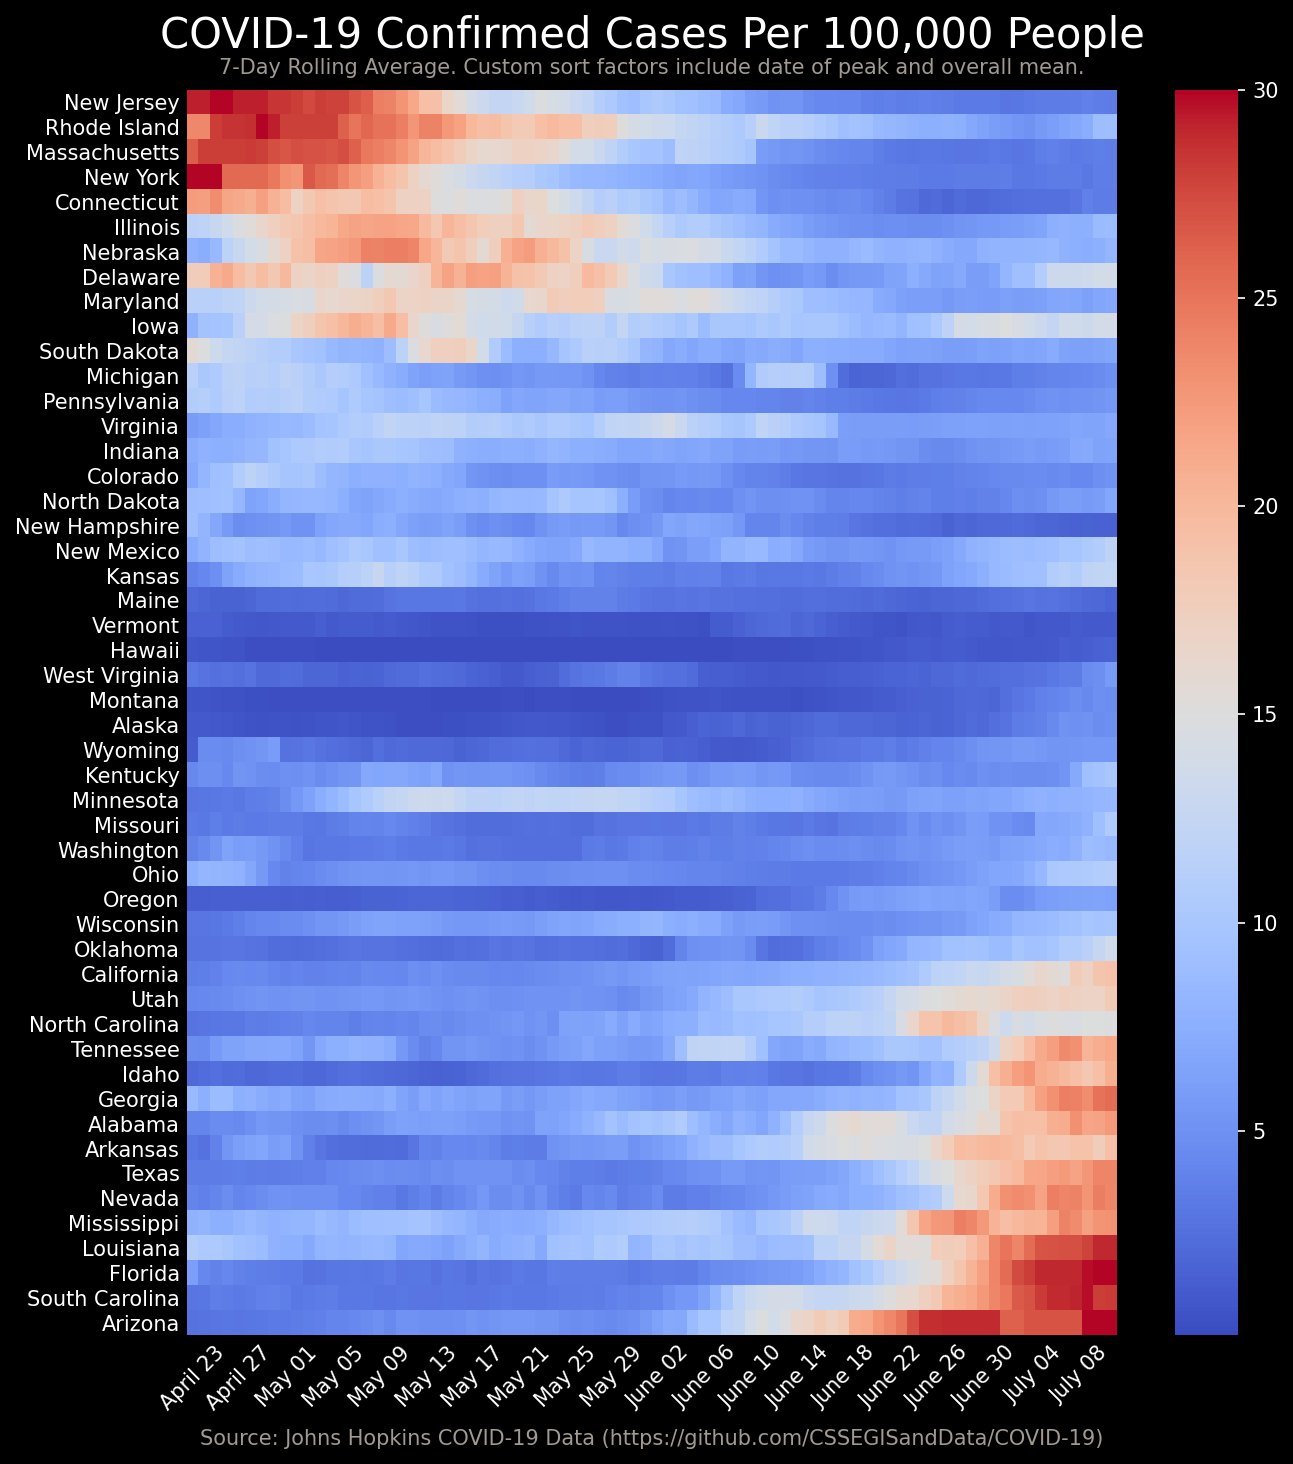

In [3]:
df = (
    get_daily_report_data()         # Get latest from the directory. 
    .copy()                         # Copy from the original to save time loading the data.
    .rename(columns={               # Rename the columns to shorter names
        'Province_State':'state', 
        'Incident_Rate':'rate'
    }) 
    [['state','date','rate']]       # Drop unnecessary columns
    .pivot(                         # Create a pivot table from the data.
        index='date', 
        columns='state', 
        values='rate'
    ) 
    .drop([                         # Keep the 50 states only.
        'Puerto Rico', 
        'American Samoa', 
        'Guam', 
        'District of Columbia', 
        'Northern Mariana Islands', 
        'Virgin Islands', 
        'Diamond Princess', 
        'Grand Princess', 
        'Recovered'
    ], axis=1)   
    .diff()                         # Get the date-to-date difference.
    .clip(0, 30)                    # Clip the data at 30 percent. Some data points are too high. 
    .replace(0, np.nan)             # Get rid of pure 0 values. We'll interpolate these.
    .interpolate()                  # Interpolate the newly NAN values.
    .rolling(window=7).mean()       # 7-Day Rolling Average for smoothness.
    .dropna()                       # Drop the first few rows which are a result of the 7-Day rolling average
)

customsort = (df.apply(lambda x: x * [a*abs(a) for a in range(int(np.ceil(-len(df.index)/2)),int(np.ceil(len(df.index)/2)))]).mean() * (df**3).mean()).sort_values()

with plt.style.context("dark_background"):
    
    fig, ax = plt.subplots(1, figsize=(10,11), dpi=150)
    idx = [d.strftime("%B %d") for d in df.index]
    xlabels = [x if i % 4 == 3 else "" for i, x in enumerate(idx)]

    ax = sns.heatmap(df[customsort.index].T, cmap='coolwarm', ax=ax, xticklabels=xlabels)
    ax.tick_params(axis='both', which='both', length=0)
    ax.set(
        xlabel='',
        ylabel=''
    )

    ax.tick_params(axis='both', which='both', length=0)
    ax.set_xticklabels(labels=xlabels, rotation=45, ha="right");
    ax.set_title('COVID-19 Confirmed Cases Per 100,000 People', size=20, pad=20)
    ax.annotate('Source: Johns Hopkins COVID-19 Data (https://github.com/CSSEGISandData/COVID-19)', 
                    (0.5,0), (0, -45), xycoords='axes fraction', color="#a19a92",
                    textcoords='offset points', size=10, va='top', ha="center")
    ax.annotate('7-Day Rolling Average. Custom sort factors include date of peak and overall mean.', 
                (0.5,1), (0, 15), xycoords='axes fraction', color="#a19a92",
                textcoords='offset points', size=10, va='top', ha="center")
    fig.savefig("covid19-incidence-case.png", dpi=300, bbox_inches="tight", pad_inches=0.5, 
                facecolor=fig.get_facecolor())
